In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
imsize = 512 if torch.cuda.is_available() else 128
loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),
    transforms.ToTensor()
])

style_img_path = "./test_image/jrm.jpg"
style_img = loader(Image.open(style_img_path)).unsqueeze(0).to(device, torch.float)
content_img_path = "./test_image/test06.jpg"
content_img = loader(Image.open(content_img_path)).unsqueeze(0).to(device, torch.float)

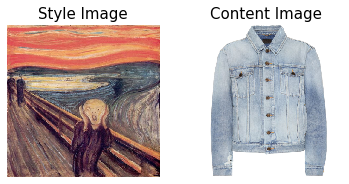

In [3]:
unloader = transforms.ToPILImage()
style_img_ = unloader(style_img.cpu().clone().squeeze(0))
content_img_ = unloader(content_img.cpu().clone().squeeze(0))
img = [style_img_, content_img_]
title = ['Style Image' , 'Content Image']

fig = plt.figure()
plt.rcParams["figure.figsize"] = (12, 12)
subfig_num = len(img)
for i in range(subfig_num):
    tmp = fig.add_subplot(1, subfig_num, i+1)
    imgplot = plt.imshow(img[i])
    tmp.set_title(title[i], fontsize=15)
    plt.axis('off')

In [4]:
vgg = models.vgg19(pretrained=True).features.to(device).eval()

In [5]:
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
        
    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input
    
def gram_matrix(input):
    a, b, c, d = input.size()
    features = input.view(a*b, c*d)
    G = torch.mm(features, features.t())
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()
        
    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [6]:
normalization_mean =  torch.tensor([0.485, 0.456, 0.406]).to(device)
normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)
        
    def forward(self, img):
        return (img - self.mean) / self.std

In [7]:
content_layers_list = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']
style_layers_list = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']

In [8]:
def model_compile(model, normalization_mean, normalization_std, 
                  style_img, content_img, content_layers, style_layers):

    content_losses = []
    style_losses = []
    
    
    normalization = Normalization(normalization_mean, normalization_std).to(device)
    new_model = nn.Sequential(normalization)
    
    i, c, r, p, b = 1, 1, 1, 1, 1
    
    cnn = copy.deepcopy(model)
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            name = 'conv{}_{}'.format(i,c)
            c += 1
        elif isinstance(layer, nn.ReLU):
            name = 'relu{}_{}'.format(i,r)
            layer = nn.ReLU(inplace=False)
            r += 1
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool{}_{}'.format(i,p)
            i += 1
            c, r, b, p = 1, 1, 1, 1
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn{}_{}'.format(i,b)
        else:
            raise RuntimeError('Unrecognized Layer: {}'.format(layer.__class__.__name__))

        new_model.add_module(name, layer)

        if name in content_layers:
            target = new_model(content_img).detach()
            content_loss = ContentLoss(target)
            new_model.add_module("ContentLoss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = new_model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            new_model.add_module("StyleLoss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    for i in range(len(new_model)-1, -1, -1):
        if isinstance(new_model[i], ContentLoss) or isinstance(new_model[i], StyleLoss):
            break
    model_ = new_model[:(i + 1)]
    return model_, style_losses, content_losses

(-0.5, 511.5, 511.5, -0.5)

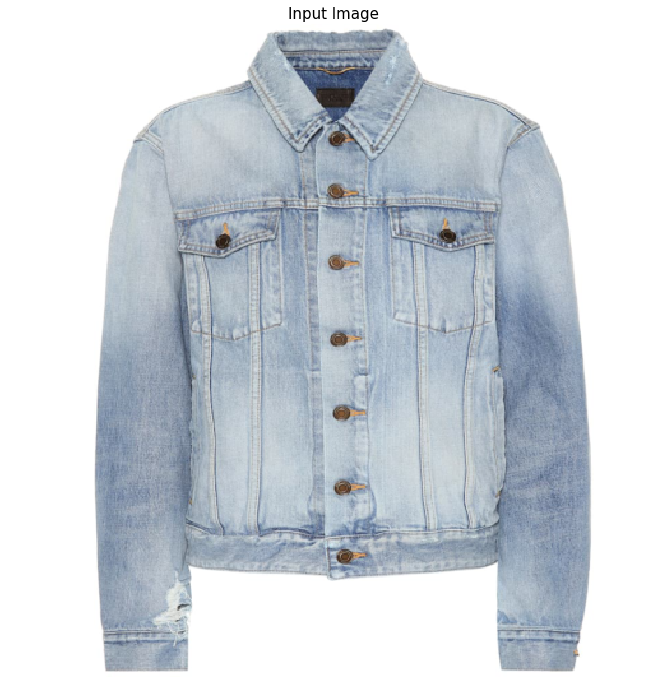

In [9]:
input_img = content_img.clone()
#input_path = './test_image/style1.jpeg'
#input_img = loader(Image.open(input_path)).unsqueeze(0).to(device, torch.float)
#input_img = torch.randn(content_img.data.size(), device=device)

unloader = transforms.ToPILImage()
input_img_ = unloader(input_img.cpu().clone().squeeze(0))

fig = plt.figure()
subfig_num = len(input_img)
tmp = fig.add_subplot(1, 1, 1)
imgplot = plt.imshow(input_img_)
tmp.set_title('Input Image', fontsize=15)
plt.axis('off')

In [10]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [11]:
k = 5
content_layers = content_layers_list[3]
style_layers = style_layers_list[:k]

num_steps = 1000
style_weight = 1000000
content_weight = 1

model, style_losses, content_losses = model_compile(vgg, normalization_mean, normalization_std, 
                                                    style_img, content_img, content_layers, style_layers)

optimizer = get_input_optimizer(input_img)

run = [0]
while run[0] <= num_steps:
    
    def closure():
        input_img.data.clamp_(0,1)
        
        optimizer.zero_grad()
        
        model(input_img)
        style_score = 0
        content_score = 0
        
        for sl in style_losses:
            style_score += sl.loss
        for cl in content_losses:
            content_score += cl.loss

        style_score *= style_weight 
        content_score  *= content_weight 
        
        loss = style_score + content_score 
        loss.backward()
        
        run[0] += 1
        if run[0] % 50 == 0:
            print("run {}".format(run))
            print("Style Loss : {:4f} Content Loss : {:4f}".format(
                style_score.item(), content_score.item()))
            print()
            
        return style_score + content_score

    optimizer.step(closure)

/home/jhpark15/.conda/envs/jhpark15/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/home/jhpark15/.conda/envs/jhpark15/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


run [50]
Style Loss : 451.388580 Content Loss : 61.031696

run [100]
Style Loss : 274.410339 Content Loss : 59.430771

run [150]
Style Loss : 179.609695 Content Loss : 58.145729

run [200]
Style Loss : 120.770821 Content Loss : 56.492630

run [250]
Style Loss : 88.913620 Content Loss : 54.606552

run [300]
Style Loss : 67.321854 Content Loss : 53.301601

run [350]
Style Loss : 50.209641 Content Loss : 52.373127

run [400]
Style Loss : 36.379681 Content Loss : 51.450459

run [450]
Style Loss : 25.921438 Content Loss : 50.747478

run [500]
Style Loss : 19.153017 Content Loss : 49.858246

run [550]
Style Loss : 15.437982 Content Loss : 49.092506

run [600]
Style Loss : 13.027358 Content Loss : 48.374069

run [650]
Style Loss : 11.498270 Content Loss : 47.745449

run [700]
Style Loss : 10.589435 Content Loss : 47.274712

run [750]
Style Loss : 10.015533 Content Loss : 46.848145

run [800]
Style Loss : 9.546990 Content Loss : 46.510277

run [850]
Style Loss : 9.153892 Content Loss : 46.2401

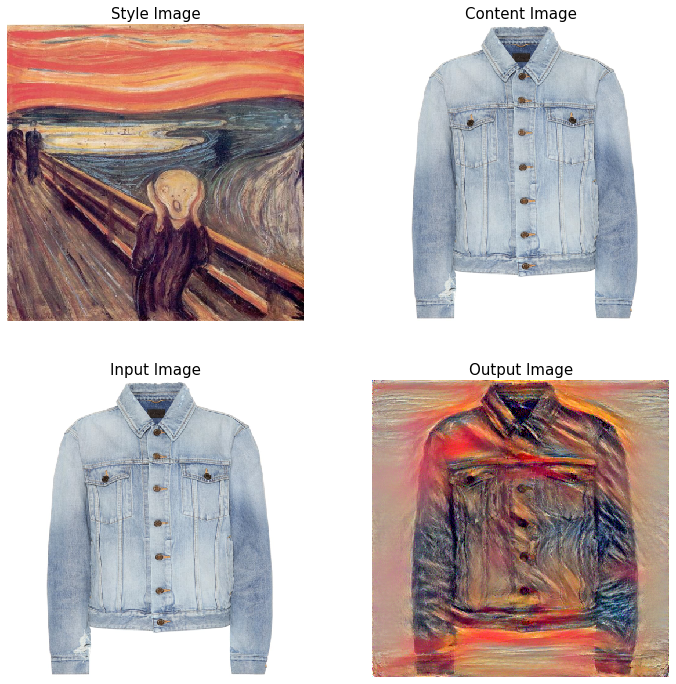

In [12]:
input_img.data.clamp_(0,1)

output_img_ = unloader(input_img.cpu().clone().squeeze(0))

img = [style_img_, content_img_, input_img_, output_img_]
title = ['Style Image' , 'Content Image', 'Input Image', 'Output Image']

fig = plt.figure()
plt.rcParams["figure.figsize"] = (12, 12)
subfig_num = len(img)
for i in range(subfig_num):
    tmp = fig.add_subplot(int(np.sqrt(subfig_num)), int(np.sqrt(subfig_num)), i+1)
    imgplot = plt.imshow(img[i])
    tmp.set_title(title[i], fontsize=15)
    plt.axis('off')